In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import numpy as np
import os
import pandas as pd

In [2]:
srcdir = f'{os.getcwd()}/pod2_first_experiment/'
colors = ['red', 'blue', 'lime', 'orange']

In [3]:
def open_csv(filename):
    content = pd.read_csv(srcdir + filename, parse_dates=['time'])
    content = content.interpolate(method='linear', limit_direction='both') # replace nan
    return content

def num(integer):
    return str(integer+1).zfill(2)

class CSVresult:
    def __init__(self):
        self.ids = []
        self.racks = [open_csv(f'sensor_strips_racks_{num(i)}_to_{num(i+2)}.csv') for i in range(0, 12, 3)]
        self.coolers = [open_csv(f'cooler_fan_temperature{num(i)}.csv') for i in range(0, 4)]
        for i in range(0, 4):
            max_q = 2.18
            df = self.coolers[i]
            dfQ = open_csv(f'cooler_fan_signal{num(i)}.csv')
            df.insert(loc=1, column='mass_flow', value=dfQ['signal_default'] / 100 * max_q)
            df.name = f'P02HDZ{num(i)}'
        for i in range(0, 12, 3):
            self.racks[int(i/3)].name = f'sensor_strips_racks_{num(i)}_to_{num(i+2)}.csv'
            self.racks[int(i/3)]['realpower_sum'] = (open_csv(f'power_rack{num(i)}.csv').sum(axis=1)+open_csv(f'power_rack{num(i+1)}.csv').sum(axis=1)+open_csv(f'power_rack{num(i+2)}.csv').sum(axis=1))/1000
        # self.racks[0]['realpower_sum'] = (open_csv('power_rack01.csv').sum(axis = 1)+open_csv('power_rack02.csv').sum(axis = 1)+open_csv('power_rack03.csv').sum(axis = 1))/1000
        # self.racks[1]['realpower_sum'] = (open_csv('power_rack04.csv').sum(axis = 1)+open_csv('power_rack05.csv').sum(axis = 1)+open_csv('power_rack06.csv').sum(axis = 1))/1000
        # self.racks[2]['realpower_sum'] = (open_csv('power_rack07.csv').sum(axis = 1)+open_csv('power_rack08.csv').sum(axis = 1)+open_csv('power_rack09.csv').sum(axis = 1))/1000
        # self.racks[3]['realpower_sum'] = (open_csv('power_rack10.csv').sum(axis = 1)+open_csv('power_rack11.csv').sum(axis = 1)+open_csv('power_rack12.csv').sum(axis = 1))/1000
        self.racks[0]['none'] = np.nan
        self.racks[1]['none'] = np.nan
        self.racks[2]['none'] = np.nan
        self.racks[3]['none'] = np.nan

    def add(self, results, id):
        self.ids += [id]
        for i in range(0, 4):
            self.coolers[i][f'sim{id}_discharge'] = results[f'P02HDZ{num(i)}_out_T']
            self.coolers[i][f'sim{id}_return0'] = results[f'P02HDZ{num(i)}_in_T']
            self.coolers[i][f'sim{id}_mass_flow'] = results[f'P02HDZ{num(i)}_out_Q']
        for i in range(0, 12, 3):
            self.racks[int(i/3)][f'sim{id}_front_temperature_top'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_t_T']
            self.racks[int(i/3)][f'sim{id}_front_temperature_middle'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_m_T']
            self.racks[int(i/3)][f'sim{id}_front_temperature_bottom'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_b_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_top'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_t_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_middle'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_m_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_bottom'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_b_T']

    def plot_cooler(self, coolerIdx):
        xaxis = 'time'
        yaxis_real = ['mass_flow', 'discharge',
                    'return0']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = [f'sim{id}_mass_flow', f'sim{id}_discharge',
                    f'sim{id}_return0']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        for a in ax:
            a.set_ylim((10, 49))
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_ylim((0, 3))
        ax[0].set_title(self.coolers[coolerIdx].name)
        ax[0].set_ylabel('Flow (m³/s)')
        ax[1].set_ylabel('Discharge (°C)')
        ax[2].set_ylabel('Return (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.coolers[coolerIdx], xaxis, yaxes, ax, labels

    def plot_rack(self, rackIdx):
        xaxis = 'time'
        yaxis_real = ['realpower_sum',
                'temperature_front_top',
                'temperature_front_middle',
                'temperature_front_bottom',
                'temperature_rear_top',
                'temperature_rear_middle',
                'temperature_rear_bottom']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = ['none',
                    f'sim{id}_front_temperature_top',
                    f'sim{id}_front_temperature_middle',
                    f'sim{id}_front_temperature_bottom',
                    f'sim{id}_rear_temperature_top',
                    f'sim{id}_rear_temperature_middle',
                    f'sim{id}_rear_temperature_bottom']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(7, 1, figsize=(8, 16), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        # if max(self.racks[rackIdx]['realpower_sum']) - min(self.racks[rackIdx]['realpower_sum']) < 0.1:
        #     ax[0].set_ylim((0, 10))
        for a in ax[1:]:
            a.set_ylim((10, 59))
        for a in ax:
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_title(self.racks[rackIdx].name)
        ax[0].set_ylabel('Power (kW)')
        ax[1].set_ylabel('Front Top (°C)')
        ax[2].set_ylabel('Front Mid (°C)')
        ax[3].set_ylabel('Front Bottom (°C)')
        ax[4].set_ylabel('Back Top (°C)')
        ax[5].set_ylabel('Back Mid (°C)')
        ax[6].set_ylabel('Back Bottom (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.racks[rackIdx], xaxis, yaxes, ax, labels

    def get_racks_rmse(self, label):
        measurements = ['front_temperature_top',
                        'front_temperature_middle',
                        'front_temperature_bottom',
                        'rear_temperature_top',
                        'rear_temperature_middle',
                        'rear_temperature_bottom']
        rmse_dicts = []
        for rackId in range(0, 4):
            rmse_dict = {'rack' : f'P02R{str(rackId+1).zfill(2)}'}
            for measurement in measurements:
                prediction = self.racks[rackId][f'sim{label}_{measurement}']
                observation = self.racks[rackId][measurement]
                rmse_dict[measurement] = np.sqrt(np.mean((prediction - observation)**2))
            rmse_dicts += [rmse_dict]
        return pd.DataFrame(rmse_dicts)

In [4]:
# Load simulation data
result = CSVresult()
result.add(open_csv('output-srt192x177x86-C01.csv'), 'LBM-SRT-192-C01')
result.add(open_csv('output-srt192x177x86-C01-new.csv'), 'LBM-SRT-192-C01-new')
# result.add(open_csv('output-srt192x177x86-C02.csv'), 'LBM-SRT-192-C02')
# result.add(open_csv('output-srt192x177x86-C005.csv'), 'LBM-SRT-192-C005')
# result.add(open_csv('output-mrt192x177x86-C01.csv'), 'LBM-MRT-192-C01')

In [5]:
result.racks[1]

,time,temperature_front_bottom,temperature_front_middle,temperature_front_top,temperature_rear_bottom,temperature_rear_middle,temperature_rear_top,realpower_sum,none,simLBM-SRT-192-C01_front_temperature_top,...,simLBM-SRT-192-C01_front_temperature_bottom,simLBM-SRT-192-C01_rear_temperature_top,simLBM-SRT-192-C01_rear_temperature_middle,simLBM-SRT-192-C01_rear_temperature_bottom,simLBM-SRT-192-C01-new_front_temperature_top,simLBM-SRT-192-C01-new_front_temperature_middle,simLBM-SRT-192-C01-new_front_temperature_bottom,simLBM-SRT-192-C01-new_rear_temperature_top,simLBM-SRT-192-C01-new_rear_temperature_middle,simLBM-SRT-192-C01-new_rear_temperature_bottom
0,2019-10-01 08:00:00,19.750,18.340000,24.190,23.690,23.2900,28.130,4.867014,NaN,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2019-10-01 08:01:00,19.750,18.350000,24.190,23.678,23.2500,28.130,4.942608,NaN,23.2886,...,17.5042,26.0820,20.8136,21.5874,21.5820,17.4229,17.3489,25.0347,20.5032,21.5391
2,2019-10-01 08:02:00,19.735,18.370000,24.220,23.690,23.2625,28.130,4.961881,NaN,26.3046,...,17.3145,28.5490,21.0411,21.3516,23.3162,17.3149,17.2751,26.1688,20.4189,21.4356
3,2019-10-01 08:03:00,19.750,18.360000,24.220,23.750,23.3050,28.116,4.923883,NaN,26.2579,...,17.3167,28.9213,21.1933,21.0999,22.9971,17.3159,17.2759,26.6080,20.4977,21.1863
4,2019-10-01 08:04:00,19.750,18.365000,24.220,23.750,23.3460,28.130,4.859321,NaN,25.9347,...,17.3133,29.1668,20.9454,21.1820,23.3565,17.3364,17.2759,26.8294,20.5683,21.2691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2019-10-01 17:55:00,18.916,17.896667,24.545,22.940,22.9360,28.130,4.802861,NaN,24.9592,...,17.0801,28.2781,21.3186,20.9240,21.6022,17.1224,17.0543,26.1041,21.1949,20.9908
596,2019-10-01 17:56:00,19.012,17.997500,24.500,23.000,22.9600,28.175,4.806013,NaN,25.5380,...,17.3037,28.5868,21.5361,21.1901,21.9225,17.3172,17.2705,26.5485,21.2395,21.2767
597,2019-10-01 17:57:00,19.060,18.102500,24.500,23.060,23.0000,28.130,4.881343,NaN,26.2084,...,17.5098,29.0095,21.5614,21.6571,22.1552,17.4981,17.4788,27.1667,20.9933,21.7370
598,2019-10-01 17:58:00,19.130,18.146667,24.500,23.145,23.0500,28.175,4.905706,NaN,26.0544,...,17.6082,28.7961,21.1154,21.9786,22.6776,17.5924,17.5800,27.0449,20.6894,22.0592


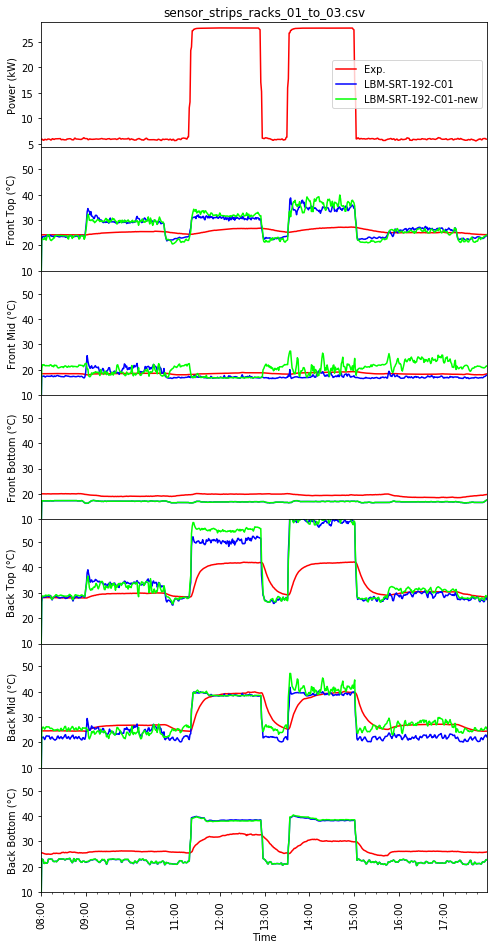

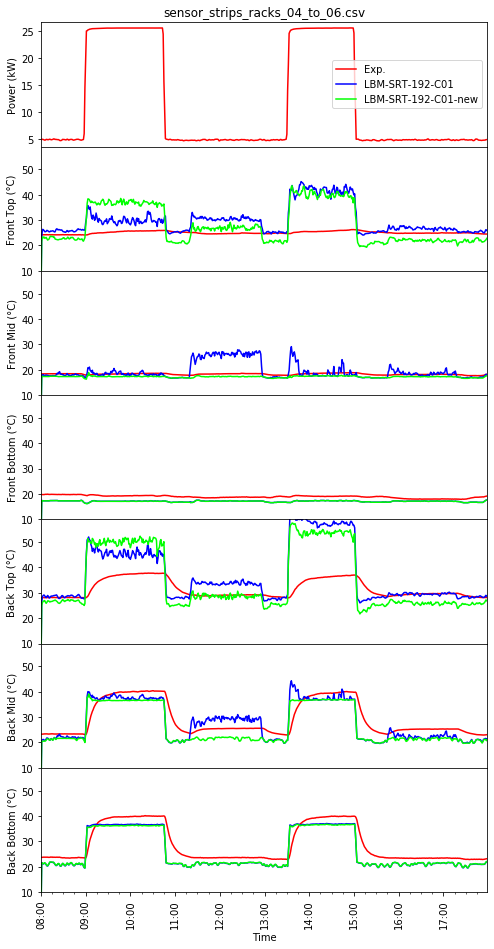

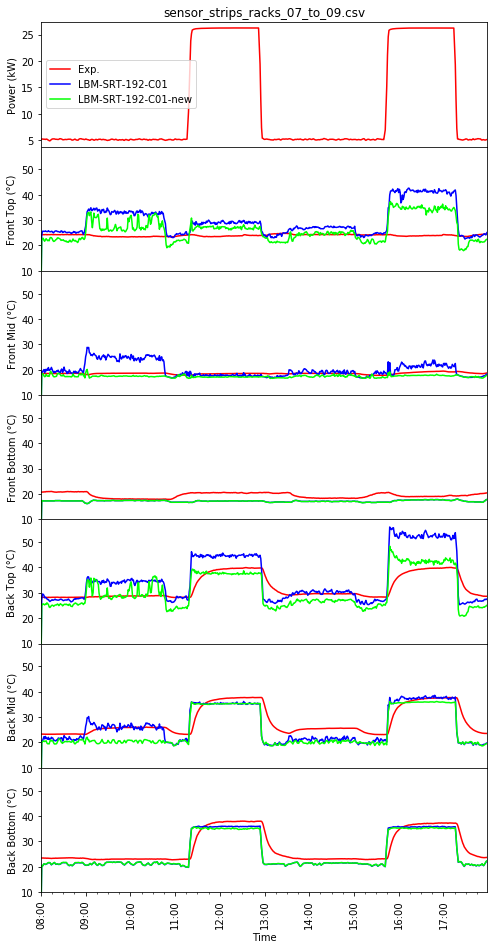

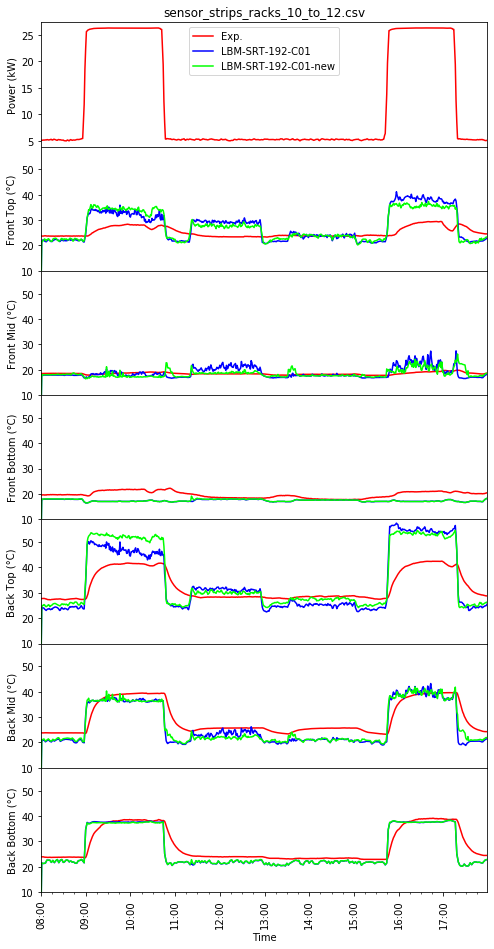

In [6]:
for rackId in range(0, 4):
    rack, xaxis, yaxes, ax, labels = result.plot_rack(rackId)
    for i in range(0, len(yaxes)):
        rack.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

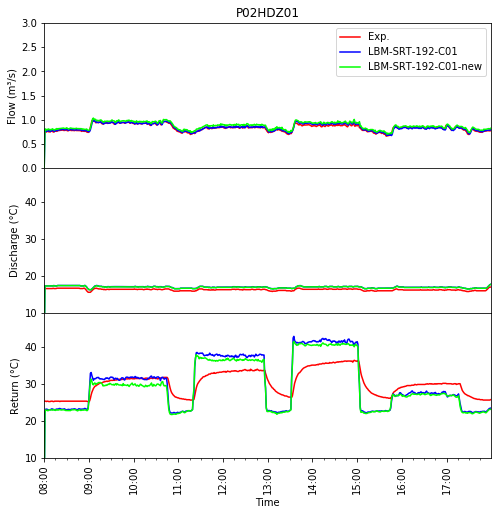

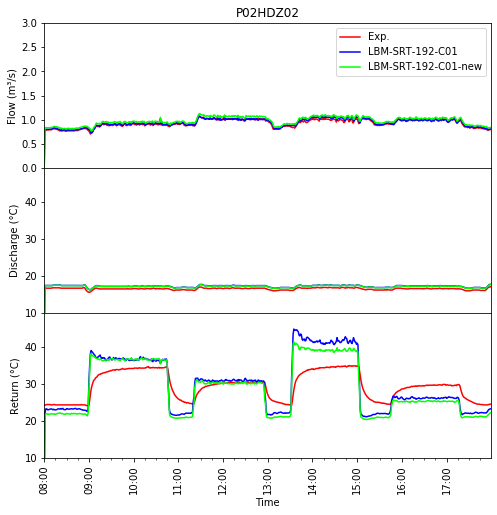

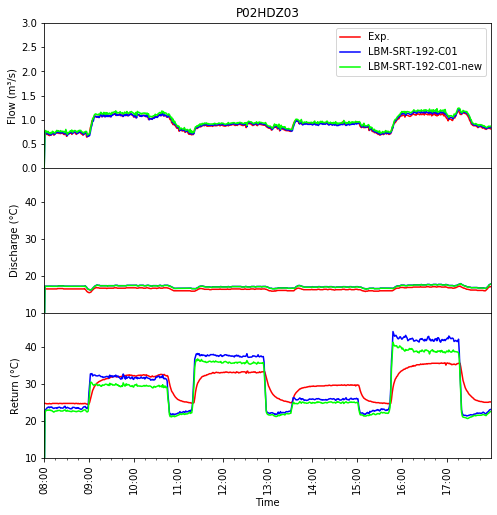

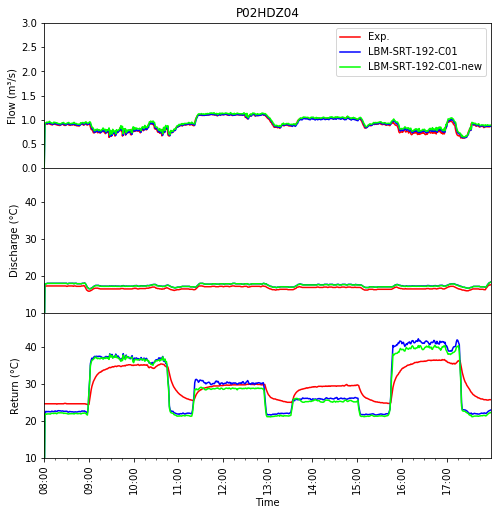

In [7]:
for coolerId in range(0, 4):
    cooler, xaxis, yaxes, ax, labels = result.plot_cooler(coolerId)
    for i in range(0, len(yaxes)):
        cooler.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

In [8]:
# result.get_racks_rmse('LBM-SRT-192')

In [9]:
# result.get_racks_rmse('LBM-MRT-192')